In [1]:
# import libraries
import requests
import re
import pandas as pd
import nltk
import os
import zipfile
import numpy as np
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import os
from sklearn.feature_extraction import text
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns
from collections import Counter
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
# To download folder
from google.colab import files
import shutil

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Upload raw data csv files to put together into one
blog = pd.read_csv('HealthcareBlog.csv')
headline = pd.read_csv('HealthcareHeadlines.csv')
reddit = pd.read_csv('Raw Reddit Data.csv')

In [3]:
# check each one
blog.head()

,word,count
0,home,1
1,edition,1
2,africa,2
3,australia,2
4,brasil,2


<ipython-input-4-b8f53a0692ea>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x='count', y='word', palette='viridis', legend = False)


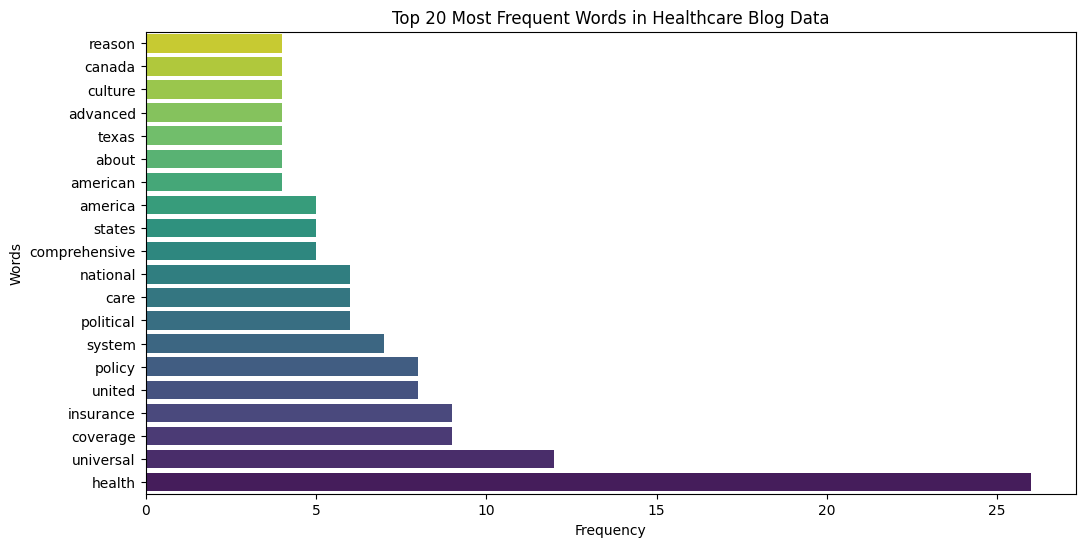

In [4]:
# Do a word frequency bar chart of blog
# Sort by count and take the top 20 most frequent words
top_n = 20
top_words = blog.sort_values(by='count', ascending=False).head(top_n)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words, x='count', y='word', palette='viridis', legend = False)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title(f'Top {top_n} Most Frequent Words in Healthcare Blog Data')
plt.gca().invert_yaxis()
plt.show()

In [5]:

headline.head()

,LABEL,Date,Source,Title,Headline
0,universal healthcare,2025-01-19,Business Insider,Universal basic income vs welfare Here s what ...,Universal basic income offers strings attached...
1,universal healthcare,2025-01-28,Business Insider,Why universal basic income is a long shot in t...,Universal basic income politically controversi...
2,universal healthcare,2025-01-29,BBC News,Five takeaways from RFK Jr s first confirmatio...,Senators grilled Robert Kennedy Trump pick hea...
3,universal healthcare,2025-01-25,BBC News,Streeting accuses Farage of miserabilist visio...,health secretary says Reform poverty ambition ...
4,universal healthcare,2025-02-13,Pitchfork,Universal Music Group Launches Mental Health F...,initiative follows pressure from several artis...


In [6]:
reddit.head()

,Comment,Score,LABEL
0,i personally am not but what i ussually hear a...,63,Conservative
1,the real question is how do i know those taxes...,11,Conservative
2,im not opposed to a universal system were very...,4,Conservative
3,why put a bandaid on an artery bleed without a...,15,Conservative
4,i dont trust the federal government running th...,10,Conservative


In [7]:
# The plan is to drop everything except the description from Headline, and the Comment from Reddit
# The labels will be used to put the two together
# Making a 'master' dataset, which I can then stem and lemmatize
headline = headline.drop(columns = ['Date', 'Source', 'Title'])
reddit = reddit.drop(columns = ['Score'])

In [8]:
headline.head()

,LABEL,Headline
0,universal healthcare,Universal basic income offers strings attached...
1,universal healthcare,Universal basic income politically controversi...
2,universal healthcare,Senators grilled Robert Kennedy Trump pick hea...
3,universal healthcare,health secretary says Reform poverty ambition ...
4,universal healthcare,initiative follows pressure from several artis...


In [9]:
reddit.head()

,Comment,LABEL
0,i personally am not but what i ussually hear a...,Conservative
1,the real question is how do i know those taxes...,Conservative
2,im not opposed to a universal system were very...,Conservative
3,why put a bandaid on an artery bleed without a...,Conservative
4,i dont trust the federal government running th...,Conservative


In [10]:
# Renaming Headline and Comment to 'Content' to match
headline.rename(columns = {'Headline':'Content'}, inplace = True)

In [11]:
headline.head()

,LABEL,Content
0,universal healthcare,Universal basic income offers strings attached...
1,universal healthcare,Universal basic income politically controversi...
2,universal healthcare,Senators grilled Robert Kennedy Trump pick hea...
3,universal healthcare,health secretary says Reform poverty ambition ...
4,universal healthcare,initiative follows pressure from several artis...


In [12]:
reddit.rename(columns = {'Comment':'Content'}, inplace = True)
reddit.head()

,Content,LABEL
0,i personally am not but what i ussually hear a...,Conservative
1,the real question is how do i know those taxes...,Conservative
2,im not opposed to a universal system were very...,Conservative
3,why put a bandaid on an artery bleed without a...,Conservative
4,i dont trust the federal government running th...,Conservative


In [13]:
# Moving the label for Reddit to the beginning to match
reddit = reddit.iloc[:, [1, 0]]
reddit.head()

,LABEL,Content
0,Conservative,i personally am not but what i ussually hear a...
1,Conservative,the real question is how do i know those taxes...
2,Conservative,im not opposed to a universal system were very...
3,Conservative,why put a bandaid on an artery bleed without a...
4,Conservative,i dont trust the federal government running th...


In [14]:
# Now concat the two by Label
masterDF = pd.concat([headline, reddit], ignore_index= True)
masterDF.head()

,LABEL,Content
0,universal healthcare,Universal basic income offers strings attached...
1,universal healthcare,Universal basic income politically controversi...
2,universal healthcare,Senators grilled Robert Kennedy Trump pick hea...
3,universal healthcare,health secretary says Reform poverty ambition ...
4,universal healthcare,initiative follows pressure from several artis...


In [15]:
# Check df
masterDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   LABEL    2112 non-null   object
 1   Content  2108 non-null   object
dtypes: object(2)
memory usage: 33.1+ KB


In [16]:
# Drop all NA Content rows
masterDF = masterDF.dropna()

In [17]:
masterDF.isna().sum()

,0
LABEL,0
Content,0


In [18]:
# Check unique labels in label column
masterDF['LABEL'].value_counts()

,count
LABEL,
AskReddit,661
Conservative,475
Liberal,333
health equity,99
universal health coverage,98
universal healthcare,97
medicaid,97
private healthcare,95
for-profit healthcare,95


In [19]:
# Now add in the blog data as a single row value
word_list = blog.loc[:, 'word'].repeat(blog.loc[:, 'count'])
word_string = ' '.join(word_list)

# Add to masterDF by concat
blogdata = pd.DataFrame({'Content': [word_string], 'LABEL': ['universal healthcare']})
masterDF = pd.concat([masterDF, blogdata])

# check results
print(masterDF.tail())


                     LABEL                                            Content
2108             AskReddit  be sure to cut belarus out of the map before d...
2109             AskReddit  my gf went to the er once via ems the closest ...
2110             AskReddit  i discovered not just bikes a few days ago hes...
2111             AskReddit  its honestly impressive and super depressing h...
0     universal healthcare  home edition africa africa australia australia...


In [20]:
# Reset index
masterDF = masterDF.reset_index(drop = True)

In [21]:
masterDF.tail()

,LABEL,Content
2104,AskReddit,be sure to cut belarus out of the map before d...
2105,AskReddit,my gf went to the er once via ems the closest ...
2106,AskReddit,i discovered not just bikes a few days ago hes...
2107,AskReddit,its honestly impressive and super depressing h...
2108,universal healthcare,home edition africa africa australia australia...


In [22]:
# Next, make all strings consistent by removing numbers and making it all lowercase
masterDF['Content'] = masterDF['Content'].str.lower()

In [23]:
masterDF.head()

,LABEL,Content
0,universal healthcare,universal basic income offers strings attached...
1,universal healthcare,universal basic income politically controversi...
2,universal healthcare,senators grilled robert kennedy trump pick hea...
3,universal healthcare,health secretary says reform poverty ambition ...
4,universal healthcare,initiative follows pressure from several artis...


In [24]:
# Saving this as a 'master raw' set.
# It's highly likely I'll add more data later. And that means I'll have to repeat this process. But I want to have this initial set too.
masterDF.to_csv('Raw Master Data.csv', index = False)

In [25]:
MyCountV=CountVectorizer(
        input="content",  ## because we have a csv file
        lowercase=True,
        stop_words = "english",
        max_features=200
        )

In [26]:
Vect1 = MyCountV.fit_transform(masterDF['Content'])

In [27]:
CountVDF = pd.DataFrame(Vect1.toarray(), columns=MyCountV.get_feature_names_out())

In [28]:
# Check results
print(CountVDF)

      able  absolutely  access  actually  afford  america  american  \
0        0           0       0         0       0        0         0   
1        0           0       0         0       0        0         0   
2        0           0       0         0       0        0         0   
3        0           0       0         0       0        0         0   
4        0           0       0         0       0        0         0   
...    ...         ...     ...       ...     ...      ...       ...   
2104     0           0       0         0       0        0         0   
2105     0           0       0         1       0        0         0   
2106     0           0       0         0       0        0         0   
2107     0           0       0         0       0        0         1   
2108     0           0       0         0       0        5         4   

      americans  arent  average  ...  wont  work  works  world  worse  \
0             0      0        0  ...     0     0      0      0      0   
1

In [29]:
# Append LABEL column back on by resetting index
CountVDF = CountVDF.reset_index(drop = True)

In [30]:
CountVDF['LABEL'] = masterDF['LABEL']


In [31]:
print(CountVDF)

      able  absolutely  access  actually  afford  america  american  \
0        0           0       0         0       0        0         0   
1        0           0       0         0       0        0         0   
2        0           0       0         0       0        0         0   
3        0           0       0         0       0        0         0   
4        0           0       0         0       0        0         0   
...    ...         ...     ...       ...     ...      ...       ...   
2104     0           0       0         0       0        0         0   
2105     0           0       0         1       0        0         0   
2106     0           0       0         0       0        0         0   
2107     0           0       0         0       0        0         1   
2108     0           0       0         0       0        5         4   

      americans  arent  average  ...  work  works  world  worse  wouldnt  \
0             0      0        0  ...     0      0      0      0        

In [32]:
# Save as csv file
CountVDF.to_csv('CountVectorizerData.csv', index = False)

In [33]:
2# Create a topics list of all topics and subreddits used
topics=["universal healthcare", "private healthcare", 'universal health coverage', 'privatized healthcare', 'medicaid', 'socialized medicine', 'health equity', 'for-profit healthcare',
        'Conservative', 'Liberal', 'AskReddit']

In [34]:
List_of_WC=[]

for mytopic in topics:

    tempdf = CountVDF[CountVDF['LABEL'] == mytopic]
    #print(tempdf)

    tempdf =tempdf.sum(axis=0,numeric_only=True)
    #print(tempdf)

    #Make var name
    NextVarName=str("wc"+str(mytopic))

    ###########
    ## Create and store in a list the wordcloud OBJECTS
    #########
    NextVarName = WordCloud(width=1000, height=600, background_color="white",
                   min_word_length=4, #mask=next_image,
                   max_words=200).generate_from_frequencies(tempdf)

    ## Here, this list holds all three wordclouds I am building
    List_of_WC.append(NextVarName)


##------------------------------------------------------------------

0
1
2
3
4
5
6
7
8
9
10


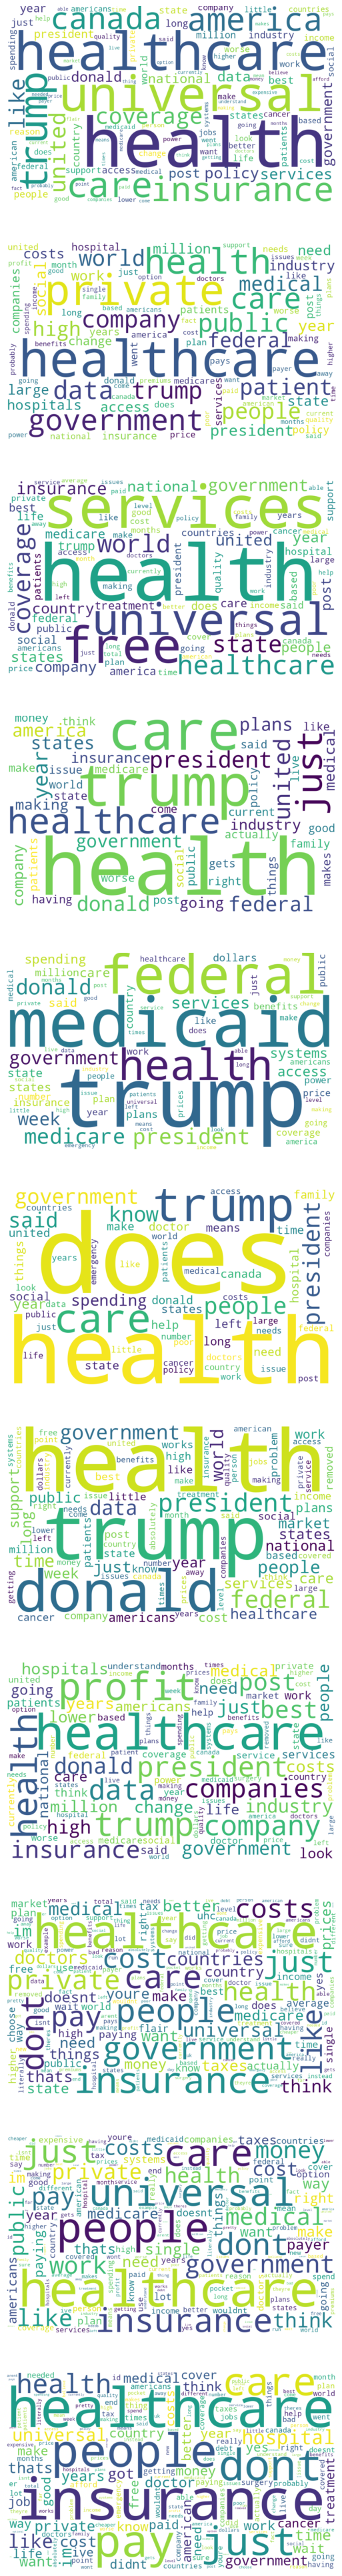

In [35]:
########## Create the wordclouds
##########
fig=plt.figure(figsize=(50, 50))
#figure, axes = plt.subplots(nrows=2, ncols=2)
NumTopics=len(topics)
for i in range(NumTopics):
    print(i)
    ax = fig.add_subplot(NumTopics,1,i+1)
    plt.imshow(List_of_WC[i], interpolation='bilinear')
    plt.axis("off")
    plt.savefig("NewClouds.pdf")

In [36]:
# Next, create a TFIDF Vectorizer set with labels
# Instantiate Vectorizer
TVect = TfidfVectorizer(
    stop_words = 'english',
    max_features = 1000,
    token_pattern = r'\b[a-zA-Z]{4,}\b' # remove numbers and words smaller than 4 characters
)

In [37]:
# Fit_transform
Vect2 = TVect.fit_transform(masterDF['Content'])

In [38]:
# Turn TFIDF matrix to an array, then turn that back to a df
ContentDF_TFIDF = pd.DataFrame(Vect2.toarray(), columns=TVect.get_feature_names_out())

In [39]:
# check results
print(ContentDF_TFIDF)

      ability  able  absolutely  accept  accepting  access  accident  \
0         0.0   0.0         0.0     0.0        0.0     0.0       0.0   
1         0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2         0.0   0.0         0.0     0.0        0.0     0.0       0.0   
3         0.0   0.0         0.0     0.0        0.0     0.0       0.0   
4         0.0   0.0         0.0     0.0        0.0     0.0       0.0   
...       ...   ...         ...     ...        ...     ...       ...   
2104      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2105      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2106      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2107      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2108      0.0   0.0         0.0     0.0        0.0     0.0       0.0   

      according  account  accounts  ...  yeah  year  yearly  years  york  \
0           0.0      0.0       0.0  ...   0.0   0.0     0.0

In [40]:
# Reset index, drop index column, add LABEL
ContentDF_TFIDF = ContentDF_TFIDF.reset_index()
ContentDF_TFIDF['LABEL'] = masterDF['LABEL']

In [41]:
# check results
print(ContentDF_TFIDF)

      index  ability  able  absolutely  accept  accepting  access  accident  \
0         0      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
1         1      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2         2      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
3         3      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
4         4      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
...     ...      ...   ...         ...     ...        ...     ...       ...   
2104   2104      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2105   2105      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2106   2106      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2107   2107      0.0   0.0         0.0     0.0        0.0     0.0       0.0   
2108   2108      0.0   0.0         0.0     0.0        0.0     0.0       0.0   

      according  account  ...  year  yearly  years 

In [42]:
# Save as csv file
ContentDF_TFIDF.to_csv("TfidfData.csv", index = False)

In [43]:
# Finally, create a stemmed and lemmatized version of the data
# First, tokenize the 'Content' column
TokenDF = masterDF['Content'].str.split()

In [44]:
TokenDF.head()

,Content
0,"[universal, basic, income, offers, strings, at..."
1,"[universal, basic, income, politically, contro..."
2,"[senators, grilled, robert, kennedy, trump, pi..."
3,"[health, secretary, says, reform, poverty, amb..."
4,"[initiative, follows, pressure, from, several,..."


In [45]:
TokenDF = TokenDF.rename('Tokens', inplace = True)

In [46]:
TokenDF = TokenDF.to_frame()

In [47]:
# check that token data is a df
print(type(TokenDF))

<class 'pandas.core.frame.DataFrame'>


In [48]:
# Remove English stopwords
stop_words = set(stopwords.words('english'))
TokenDF['Tokens'] = TokenDF['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])
print(TokenDF['Tokens'])

0       [universal, basic, income, offers, strings, at...
1       [universal, basic, income, politically, contro...
2       [senators, grilled, robert, kennedy, trump, pi...
3       [health, secretary, says, reform, poverty, amb...
4       [initiative, follows, pressure, several, artis...
                              ...                        
2104                    [sure, cut, belarus, map, though]
2105    [gf, went, er, via, ems, closest, hospital, se...
2106    [discovered, bikes, days, ago, hes, youtube, c...
2107    [honestly, impressive, super, depressing, effe...
2108    [home, edition, africa, africa, australia, aus...
Name: Tokens, Length: 2109, dtype: object


In [49]:
# Intantiate Stemmer and Lemmer
STEMMER=PorterStemmer()
LEMMER = WordNetLemmatizer()

In [50]:
# Stem the data as a new column in a new dataframe
StemData = TokenDF.copy()

StemData['Stemmed'] = StemData['Tokens'].apply(lambda x: [STEMMER.stem(word) for word in x])

StemData['LABEL'] = masterDF['LABEL'] # Add back labels

In [51]:
# Check results
StemData.head()

,Tokens,Stemmed,LABEL
0,"[universal, basic, income, offers, strings, at...","[univers, basic, incom, offer, string, attach,...",universal healthcare
1,"[universal, basic, income, politically, contro...","[univers, basic, incom, polit, controversi, wa...",universal healthcare
2,"[senators, grilled, robert, kennedy, trump, pi...","[senat, grill, robert, kennedi, trump, pick, h...",universal healthcare
3,"[health, secretary, says, reform, poverty, amb...","[health, secretari, say, reform, poverti, ambi...",universal healthcare
4,"[initiative, follows, pressure, several, artis...","[initi, follow, pressur, sever, artist, chappe...",universal healthcare


In [52]:
# Repeat process for Lemmatized Data
LemmData = TokenDF.copy()

LemmData['Lemmatized'] = LemmData['Tokens'].apply(lambda x: [LEMMER.lemmatize(word) for word in x])

LemmData['LABEL'] = masterDF['LABEL'] # Add back labels

In [53]:
# check results
LemmData.head()

,Tokens,Lemmatized,LABEL
0,"[universal, basic, income, offers, strings, at...","[universal, basic, income, offer, string, atta...",universal healthcare
1,"[universal, basic, income, politically, contro...","[universal, basic, income, politically, contro...",universal healthcare
2,"[senators, grilled, robert, kennedy, trump, pi...","[senator, grilled, robert, kennedy, trump, pic...",universal healthcare
3,"[health, secretary, says, reform, poverty, amb...","[health, secretary, say, reform, poverty, ambi...",universal healthcare
4,"[initiative, follows, pressure, several, artis...","[initiative, follows, pressure, several, artis...",universal healthcare


In [54]:
# Save as CSV files
StemData.to_csv('StemmedData.csv', index = False)
LemmData.to_csv('LemmatizedData.csv', index = False)

In [55]:
# That's it for the creation of my main datasets (for now).